# Projeto de ICD - Dota 2

#### Alunos:
    Gabriel Henrique
    Matheus Vargas
    Raydan Gaspar

# Vídeo no Youtube 5 minutos

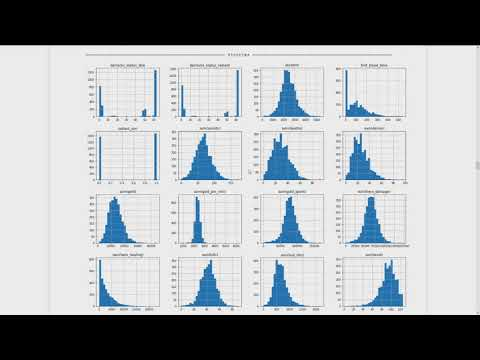

In [14]:
from IPython.display import YouTubeVideo
YouTubeVideo('E_PlU243BEo')

# Introdução

![](img/dota_logo.png)

# Tema

Dota 2 é um jogo eletrônico do gênero Multiplayer Online Battle Arena (MOBA, "arena de batalha multijogador online"), também conhecido como Action Real-Time Strategy (ARTS, "estratégia de ação em tempo real") onde o jogador controla um personagem em uma batalha entre dois times, cujo objetivo é derrotar a equipe adversária e, para isso, é, indispensavelmente, necessário destruir o Ancestral (Ancient), que, por sua vez, se localiza no centro da base inimiga. Cada base é defendida por torres e ondas de unidades (chamadas de creeps) que percorrem os caminhos principais do mapa (chamadas de trilhas, ou lanes) que levam à suas bases. Existem 3 trilhas no mapa do jogo, que por convenção são chamadas de trilha de cima (Top, atravessa a parte de cima do mapa), trilha do meio (Mid ou Middle, caminho que atravessa o centro do mapa) e trilha de baixo (Bot ou Bottom, caminho que atravessa a parte de baixo do mapa). 

Na imagem abaixo podemos ver o minimapa do Dota2 e ao lado um diagrama representando o layout de um jogo do gênero MOBA, onde os pontos roxos e rosas representam as torres de cada time, com exceção do maior ponto localizado nos cantos da imagem dentro de cada base, que representa o Ancient.

| ![](img/minimaps.png)|
|:--:| 
| **Figura 1**: Minimapa do Dota 2 (esquerda) e layout padrão de jogos MOBA (direita) |


## Motivação

Afim de colocar em prática os assuntos desenvolvidos em sala, o netebook a seguir busca extrair da base de dados, informações relevantes para o entendimento da mecânica de jogo e mensuração de estatíscas sobre as partidas.

## Pergunta de Pesquisa

O que define uma partida de dota?

# Descrição da base
Os dados foram coletados utilizando a API não oficial do jogo, chamada OpenDoTA, nela coletamos dados de várias partidas do ano de 2015, assim como os dados dos jogadores presentes em cada partida e todas as suas ações, como por exemplo as coordenadas das posições que o jogador passou durante a partida, o herói que escolheu, quantas vezes morreu, entre outros. Nós optamos por utilizar os mesmos dados que usamos no trbalho final de Introdução a Banco de dados, mas os dados coletados foram disponibilizados em formato json, e não em formato de tabelas como precisávamos, então foi preciso selecionar os dados que queríamos entre aqueles fornecidos pela API e montar um banco de dados a partir deles. 

Uma característica do formato json é usar o tipo abstrato de dados dicionário, que é composto de pares de chaves e valores, onde cada chave pode conter uma lista de outras chaves e seus valores, isso faz com que existam várias "sub-tabelas" nos dados, o que impossibilita a importação dos dados diretamente para um banco de dados convencional. Dessa forma, foram criadas tabelas separadas para cada conjunto de valores do json, sendo que cada tabela referencia o seu "pai" original através de chaves estrangeiras, dessa forma conseguimos manter a relação dos dados como era originalmente feito no json.

Um exemplo dos dados pode ser visto na imagem abaixo.

| ![](img/exemplo_json.png) |
|:--:| 
| **Figura 2**: Amostra dos dados coletados em formato json |

Alguns dados não podiam ser buscados através da API, como por exemplo os nomes e números identificadores de cada personagem ou item do jogo, que são informações constantes, que não mudam entre as partidas, mas precisávamos dessas informações uma vez que a maior parte dos dados é numérica, e não seria interessante ter apenas números, mas sim nomes e significados para que os dados fizessem mais sentido. Por fim encontramos esses dados também em formato json, compatíveis com os dados da API, o que fez com que ficasse mais natural a relação entre as informações.

A imagem abaixo mostra um exemplo dos dados constantes de itens do jogo, com o id e nome de cada item listado em formato json.

| ![](img/exemplo_constantes.png) | 
|:--:| 
| **Figura 3**:  Dados constantes do jogo, servem de referência para os dados das partidas |


# Métodos e modelos utilizados. 
**Intervalo de Confiança:** Bootstraping: Utilizamos as amostras da população total, e de técnicas de reamostragem para fornecer uma estimativa precisa da variação na distribuição normal.

Tal técnica pode ser justicada uma vez que a base utilizada é parte de um conjunto de dados maior que significa a totalidade de partidas. Logo a base pode ser concebida como uma amostra da população total e, uma amostra dessa amostra, deve se comportar, a partir do uso dessa técnica, como o resultado da análise da população.

**Testes de Hipótese:** Para o caso dos testes de hipóses, utilizamos a total variation distance para medir a relação entre as proporções de cada classe de heroes presentes na equipe vencedora (melee, ranged) e dessa forma definir qual a configuração de proporções tende a ser mais vencedora.

**Regressão Linear:** Para conseguirmos estimar o valor esperado do número de assassinatos do jogador observando os last hits totais do jogador no fim da partida, e para entendermos a natureza desse relacionamento, utilizamos a regressão linear simples.

Utilizamos dessa fórmula, com alpha, beta e o erro, para chegarmos ao valor esperado: $$\hat{y}_i = \beta x_i + \alpha + \epsilon_i$$
Calculamos o $R^2$, para verificarmos o quão bem nosso modelo se ajusta aos dados, e utilizamos o Coeficiente de Correlação de Pearson para verificar a correlação do modelo.

Mais a frente, utilizamos o Bootstrap para saber a variablidade da estimativas encontradas.

# Resultados
### Caracterização (análise exploratória)
Neste trabalho, utilizaremos dados de partidas online do jogo eletrônico Dota 2 realizadas no ano de 2015. Nosso objetivo aqui é fazer uma investigação inicial dos dados, a fim de detectar problemas, necessidade de mais variáveis, falhas na organização e na transformação da informação, assim como obter um entendimento melhor dos dados em si.

O primeiro passo é importar as bibliotecas que vamos utilizar.

In [1]:
import numpy as np # Álgebra linear
import pandas as pd # Dataframes
from matplotlib import pyplot as plt # Plot dos gráficos
import sqlite3 # Acesso e manipulação do banco de dados
import seaborn as sns # # Gráficos

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

Agora precisamos fazer a conexão com o banco de dados, nesse caso estamos utilizando um banco no formato SQLite, que contém todas as tabelas que vamos utilizar.

In [2]:
conn = sqlite3.connect('dota2_2800_partidas.db')
cursor = conn.cursor()

Como se trata de um banco de dados relacional, precisamos verificar quais tabelas existem

In [3]:
df_all_tables = pd.read_sql_query('''SELECT name FROM sqlite_master WHERE type = 'table';''', conn)

print('Número de tabelas na base de dados:', df_all_tables.shape[0])
df_all_tables

Número de tabelas na base de dados: 22


,name
0,xp_reasons
1,lobby_type
2,item_ids
3,gold_reasons
4,order_types
5,game_mode
6,heroes
7,match
8,player
9,chat


Sabemos que as tabelas principais são 'match' e 'player', vamos ver como os dados nessas tabelas estão distribuídos.

Primeiro vamos analisar a tabela das partidas.

In [4]:
df_match = pd.read_sql_query('''SELECT * FROM match''', conn)

print('Shape da tabela match:', df_match.shape)
df_match.describe()

Shape da tabela match: (2856, 11)


,match_id,game_mode,lobby_type,radiant_win,duration,human_players,tower_status_dire,tower_status_radiant,barracks_status_radiant,barracks_status_dire,first_blood_time
count,2.856000e+03,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000
mean,2.001266e+09,11.110294,3.314426,0.518207,2420.041667,9.980742,987.857843,1046.056373,35.870798,35.850490,103.202381
std,5.818412e+04,10.124103,3.448782,0.499756,683.281324,0.309760,943.530362,947.662790,29.678094,29.127626,93.890709
min,2.001166e+09,1.000000,0.000000,0.000000,120.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.001218e+09,1.000000,0.000000,0.000000,1992.750000,10.000000,0.000000,0.000000,0.000000,0.000000,15.000000
50%,2.001263e+09,4.000000,1.000000,1.000000,2374.000000,10.000000,455.000000,1584.000000,51.000000,51.000000,88.000000
75%,2.001315e+09,22.000000,7.000000,1.000000,2844.250000,10.000000,1974.000000,1974.000000,63.000000,63.000000,156.000000
max,2.001401e+09,22.000000,7.000000,1.000000,5382.000000,10.000000,2047.000000,2047.000000,63.000000,63.000000,542.000000


Sabemos que temos XXX partidas no banco, então podemos esperar cerca de 10 vezes esse número na tabela de players, já que em geral são 10 por partida. Podemos notar também que o time Radiant ganha em pouco mais da metade das partidas. Outro dado importante é que existem partidas com bots na base, uma vez que a coluna 'human_players' não tem média igual a 10.

Agora vamos analisar os dados da tabela de jogadores.

In [5]:
df_player = pd.read_sql_query('''SELECT * FROM player''', conn)

pd.set_option('display.max_columns', 23)
print('Shape da tabela player:', df_player.shape)
df_player.describe()

Shape da tabela player: (28505, 23)


,player_match_id,gold_spent,gold,xp_per_min,level,hero_id,hero_healing,hero_damage,leaver_status,tower_damage,last_hits,kills,denies,deaths,gold_per_min,item_0,item_1,item_2,item_3,item_4,item_5,assists,player_slot
count,2.850500e+04,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.00000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000,28505.000000
mean,2.001266e+09,13506.508332,1830.354885,435.537485,17.505631,51.739028,456.025083,11603.238274,0.06234,1252.982319,123.232661,6.980810,4.771759,7.254341,404.192493,97.505631,99.503245,92.472408,87.609577,80.930644,69.257920,11.062691,66.011226
std,5.814627e+04,6488.119730,1711.936343,148.238260,4.655382,33.264024,1204.339012,6712.852761,0.34761,1749.874046,97.732153,5.395645,5.557336,3.832032,139.117868,71.634543,70.001925,69.368166,68.748821,69.478602,69.529959,6.442428,64.016745
min,2.001166e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.001217e+09,9035.000000,555.000000,330.000000,14.000000,21.000000,0.000000,6692.000000,0.00000,103.000000,51.000000,3.000000,1.000000,4.000000,307.000000,41.000000,41.000000,38.000000,36.000000,23.000000,0.000000,6.000000,2.000000
50%,2.001263e+09,12635.000000,1304.000000,429.000000,18.000000,50.000000,0.000000,10393.000000,0.00000,524.000000,99.000000,6.000000,3.000000,7.000000,385.000000,81.000000,98.000000,79.000000,63.000000,63.000000,46.000000,10.000000,128.000000
75%,2.001315e+09,17050.000000,2661.000000,533.000000,21.000000,79.000000,188.000000,15185.000000,0.00000,1621.000000,169.000000,10.000000,7.000000,10.000000,484.000000,154.000000,152.000000,147.000000,145.000000,139.000000,117.000000,15.000000,130.000000
max,2.001401e+09,63095.000000,17232.000000,1187.000000,25.000000,112.000000,16195.000000,57065.000000,4.00000,13321.000000,1095.000000,43.000000,79.000000,40.000000,2500.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,47.000000,132.000000


Como esperado, temos cerca que 10 jogadores para cada partida (não exatamente por causa da existência de partidas com bots que não contam como jogadores na nossa base). Alguns dados importantes que conseguimos ver são, a média de 'kills', 'deaths' e 'assists' que compoem uma estatística chamada KDA, muito usada no jogo. A quantidade de gold e experiência por minuto também é um dado interessante, que pode interferir no resultado da partida. Também podemos usar a quantidade de last_hits para prever o quão forte um jogador vai ficar e quantos kills ele pode conseguir fazer na partida, por exemplo.

Para condensar os dados em um único dataframe, para ajudar em algumas análises, precisamos encontrar uma forma de unir as tabelas. Sabemos que em cada partida, existem 10 jogadores, 5 em cada um dos dois times, já que vamos ignorar as partidas com bots, então uma maneira de condensar os dados é somando as estatísticas de cada time e adicionar essas estatísticas nas linhas de cada partida, separando as partidas por time, ou seja, onde antes existia uma entrada por partida, agora irá existir uma entrada por time para cada uma das partidas.

In [6]:
df = pd.read_sql_query('''
SELECT *
FROM match AS m
INNER JOIN
    (SELECT player_match_id,REPLACE(REPLACE(sum(player_slot),10,"Radiant"),650,"Dire") Team,sum(gold_spent),sum(gold),sum(xp_per_min),sum(level),sum(hero_healing),sum(hero_damage),sum(tower_damage),sum(last_hits),sum(kills),sum(denies),sum(deaths),sum(gold_per_min),sum(assists)
    FROM player
    WHERE player_slot < 5
    GROUP BY player_match_id
    UNION
    SELECT player_match_id,REPLACE(REPLACE(sum(player_slot),10,"Radiant"),650,"Dire") Team,sum(gold_spent),sum(gold),sum(xp_per_min),sum(level),sum(hero_healing),sum(hero_damage),sum(tower_damage),sum(last_hits),sum(kills),sum(denies),sum(deaths),sum(gold_per_min),sum(assists)
    FROM player
    WHERE player_slot > 5
    GROUP BY player_match_id) AS p
ON m.match_id = p.player_match_id
INNER JOIN
    (SELECT id game_mode_id, name game_mode_name
    FROM game_mode
    ) as gm
ON m.game_mode = gm.game_mode_id
INNER JOIN
    (SELECT id lobby_type_id, name lobby_type_name
    FROM lobby_type 
    ) as lt
ON m.lobby_type = lt.lobby_type_id
WHERE human_players = 10
''', conn)

# Eliminando colunas desnecessárias (indices irrelevantes)
df.drop(['game_mode','lobby_type','game_mode_id','lobby_type_id', 'player_match_id', 'human_players'], axis=1, inplace=True)

pd.set_option('display.max_columns', 50)
df.head(6)

,match_id,radiant_win,duration,tower_status_dire,tower_status_radiant,barracks_status_radiant,barracks_status_dire,first_blood_time,Team,sum(gold_spent),sum(gold),sum(xp_per_min),sum(level),sum(hero_healing),sum(hero_damage),sum(tower_damage),sum(last_hits),sum(kills),sum(denies),sum(deaths),sum(gold_per_min),sum(assists),game_mode_name,lobby_type_name
0,2001166109,1,1819,256,2047,63,48,0,Dire,36735,3570,1549,64,286,48284,77,342,17,6,50,1526,36,game_mode_all_draft,lobby_type_ranked
1,2001166109,1,1819,256,2047,63,48,0,Radiant,66660,9367,2509,82,5768,64645,10105,401,49,18,19,2474,75,game_mode_all_draft,lobby_type_ranked
2,2001166147,1,1717,4,1958,63,3,3,Dire,35855,4110,1566,63,4530,33873,1588,364,14,23,46,1633,26,game_mode_captains_mode,lobby_type_practice
3,2001166147,1,1717,4,1958,63,3,3,Radiant,64020,8413,2379,77,2035,68854,8082,375,46,35,16,2529,91,game_mode_captains_mode,lobby_type_practice
4,2001166161,0,2090,1975,0,0,63,106,Dire,73395,9740,2588,90,1673,46618,12514,575,33,12,26,2476,49,game_mode_all_pick,lobby_type_normal
5,2001166161,0,2090,1975,0,0,63,106,Radiant,39220,4374,1845,75,1584,45128,1066,389,24,22,34,1441,25,game_mode_all_pick,lobby_type_normal


Verificamos rapidamente se existem valores nulos entre os dados

In [7]:
# 0 significa que nenhum valor na tabela é nulo
df.isnull().sum().max()

0

As colunas presentes no dataset são as seguintes

In [8]:
df.columns

Index(['match_id', 'radiant_win', 'duration', 'tower_status_dire',
       'tower_status_radiant', 'barracks_status_radiant',
       'barracks_status_dire', 'first_blood_time', 'Team', 'sum(gold_spent)',
       'sum(gold)', 'sum(xp_per_min)', 'sum(level)', 'sum(hero_healing)',
       'sum(hero_damage)', 'sum(tower_damage)', 'sum(last_hits)', 'sum(kills)',
       'sum(denies)', 'sum(deaths)', 'sum(gold_per_min)', 'sum(assists)',
       'game_mode_name', 'lobby_type_name'],
      dtype='object')

Com esse dataframe em mãos, podemos visualizar algumas estatísticas interessantes das partidas

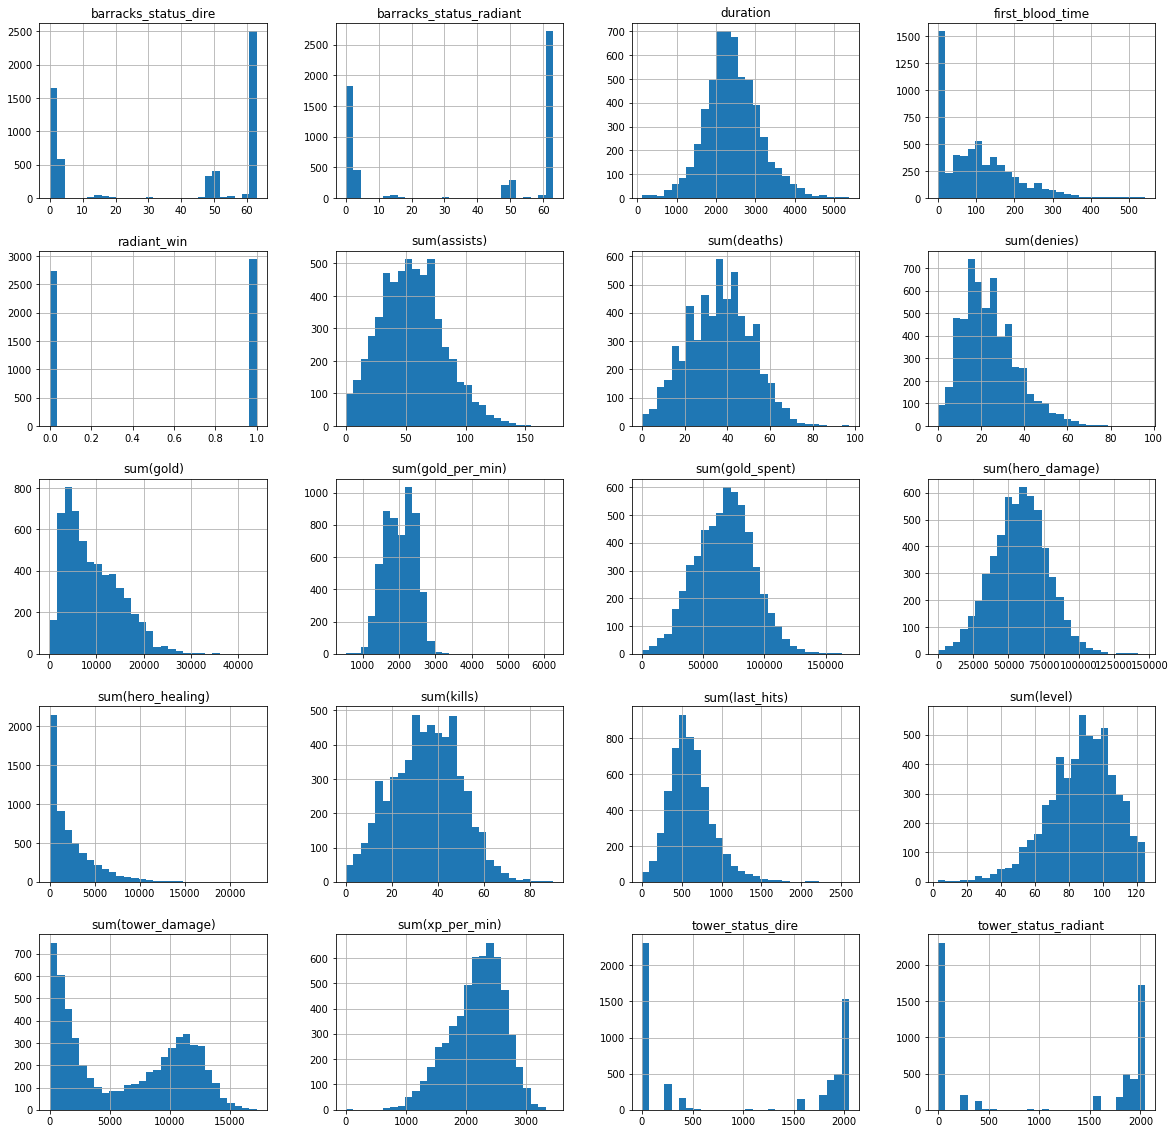

In [9]:
# Não é necessário visualizar o identificador das partidas
df_stats = df.drop(['match_id'], axis=1)

df_stats.hist(figsize=(20,20), bins=28)
plt.show()

Algumas das estatísticas é interessante ver em mais detalhe

### Distribuição das vitórias por time
Aqui podemos ver que a quantidade de vitórias por time é mais ou menos balanceada.

Text(0, 0.5, 'Quantidade de vitórias')

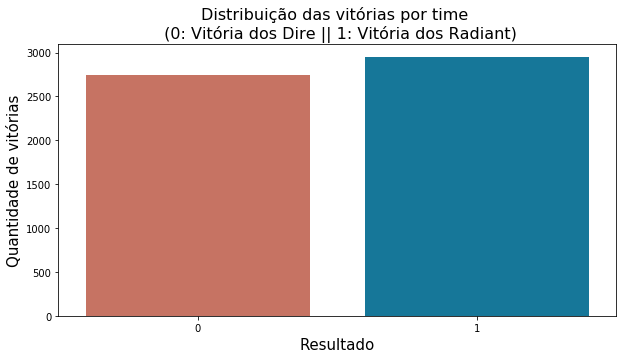

In [10]:
colors = ["#d66853", "#0081af"]
plt.figure(figsize=(10,5))
sns.countplot('radiant_win', data=df, palette=colors)
plt.title('Distribuição das vitórias por time \n (0: Vitória dos Dire || 1: Vitória dos Radiant)', fontsize=16)
plt.xlabel('Resultado', fontsize=15)
plt.ylabel('Quantidade de vitórias', fontsize=15)

### Histograma da duração das partidas

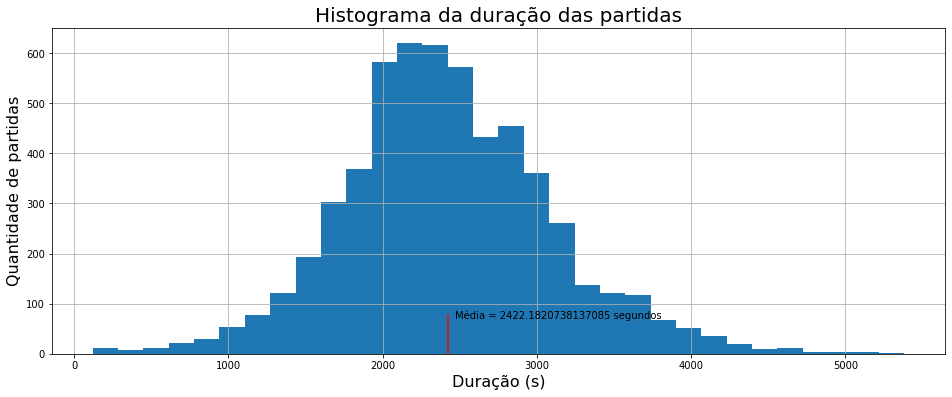

In [11]:
plt.xlabel('Duração (s)', fontsize=16)
plt.ylabel('Quantidade de partidas', fontsize=16)
plt.title('Histograma da duração das partidas', fontsize=20)

media = df['duration'].mean()

plt.vlines(media, 0, 80, color='red')
plt.text(media+50, 70, 'Média = '+str(media)+' segundos')

df['duration'].hist(figsize=(16,6),bins=32)

### Tempo em que acontece o first blood

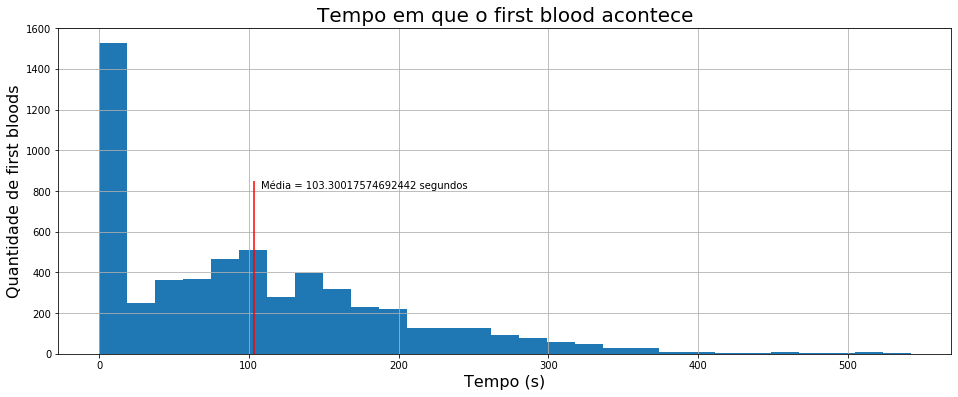

In [12]:
plt.xlabel('Tempo (s)', fontsize=16)
plt.ylabel('Quantidade de first bloods', fontsize=16)
plt.title('Tempo em que o first blood acontece', fontsize=20)

media = df['first_blood_time'].mean()

plt.vlines(media, 0, 850, color='red')
plt.text(media+5, 810, 'Média = '+str(media)+' segundos')

df['first_blood_time'].hist(figsize=(16,6),bins=29)

### Diferenças entre a vitória e derrota

Agora vamos ver como ficam distribuídas as estatísticas dependendo do resultado da partida (vitória e derrota). Separamos o dataset em dois, um apenas com as vitórias e outro apenas com as derrotas.



=================================================== Vitórias ===================================================


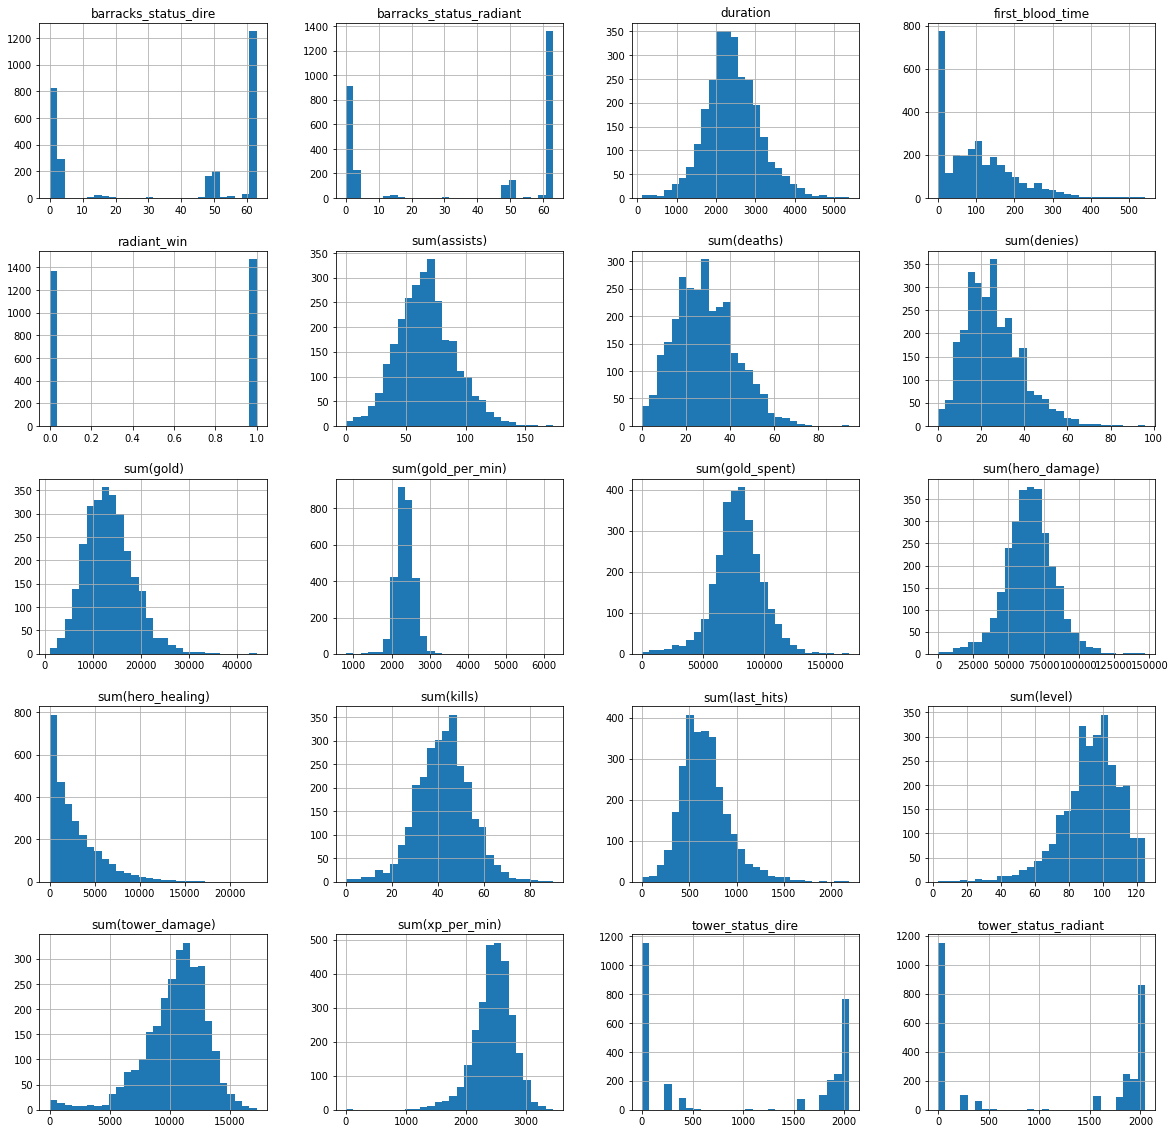



=================================================== Derrotas ===================================================


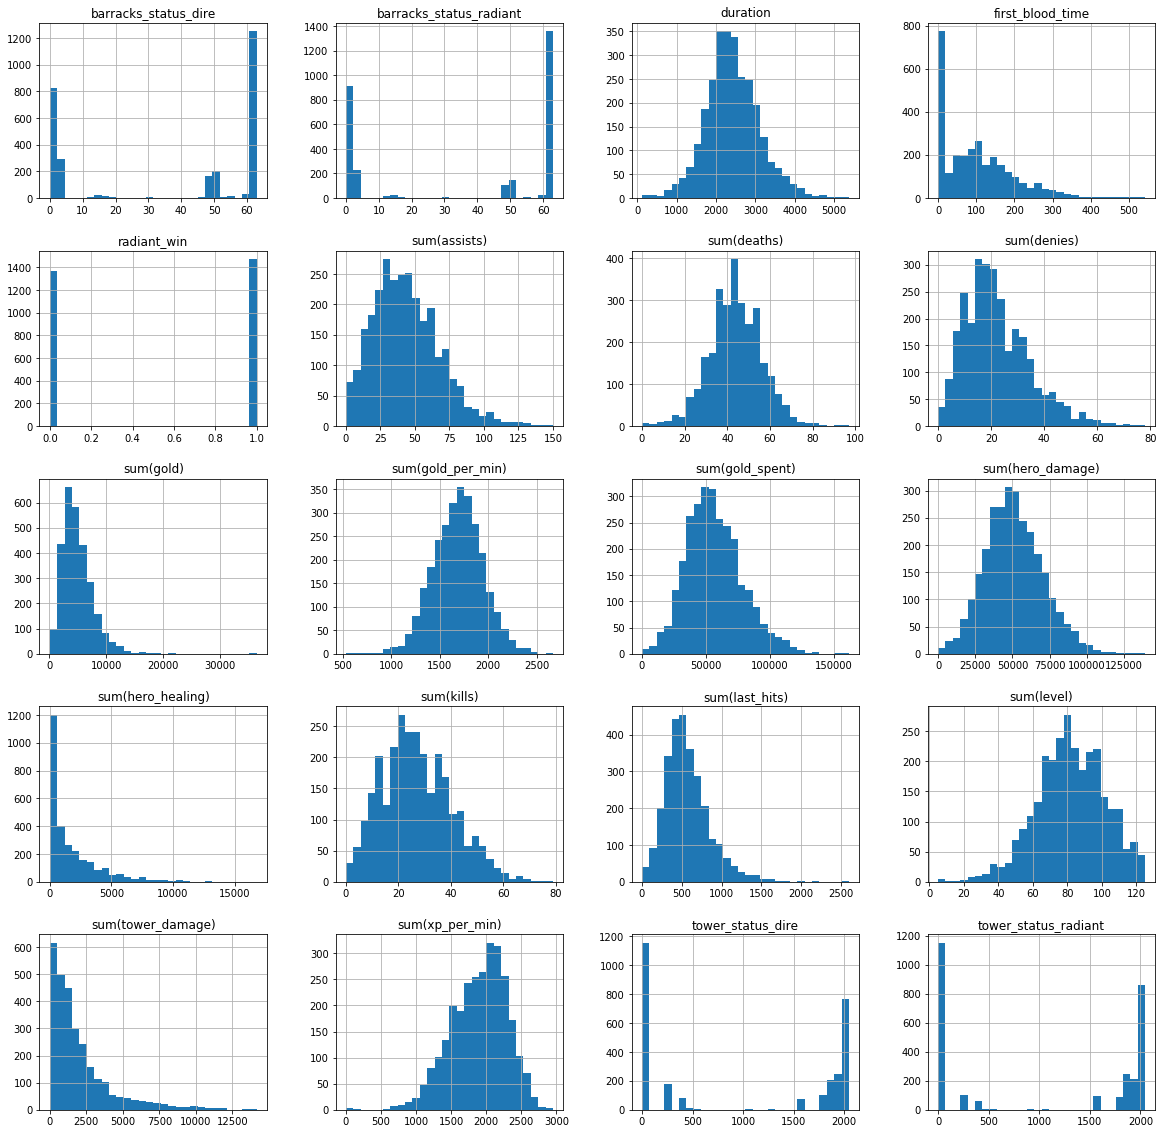

In [13]:
# Dataframe contendo apenas vitórias
df_wins = df[((df.radiant_win == 1) & (df.Team == 'Radiant')) | ((df.radiant_win == 0) & (df.Team == 'Dire'))]

# Dataframe contendo apenas derrotas
df_losses = df[((df.radiant_win == 0) & (df.Team == 'Radiant')) | ((df.radiant_win == 1) & (df.Team == 'Dire'))]

print("\n\n=================================================== Vitórias ===================================================")
df_wins.drop(['match_id'], axis=1).hist(figsize=(20,20), bins=28)
plt.show()
print("\n\n=================================================== Derrotas ===================================================")
df_losses.drop(['match_id'], axis=1).hist(figsize=(20,20), bins=28)
plt.show()

### Conclusão da análise exploratória

Agora que já fizemos uma análise prévia do que está contido no nosso dataset, podemos concluir que os dados mostram claramente várias tendências, que podem ser usadas para se fazer previsões ou classificações, principalmente na diferença entre os dados das vitórias e derrotas, o que significa que temos dados ótimos para realizar nossas análises.

In [15]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')


## Intervalo de Confiança
Para os testes seguintes o objetivo é garantir com porcentagem aceitavel que as afirmações feitas possam ser provadas utilizando uma amostras sufucientementes grandes, permitindo estimar com o menor viés os parâmetros desejados.

Objetivo: 
Provar, a partir dos dados disponíveis e de amostras da população com 95% de certeza eu a duração média das partidas está presente no intervalo entre 30 e 40 minutos.


In [16]:
match_durations = pd.read_sql_query(
'''
SELECT duration
FROM match
''', conn)

Primeiramente vamos categorizar os tempos de partida separando a população em:

*  Partidas com duração menor que 10 minutos
*  Partidas com duração menor que 20 minutos e maior que 10 minutos
*  Partidas com duração menor que 30 minutos e maior que 20 minutos
*  Partidas com duração menor que 40 minutos e maior que 30 minutos
*  Partidas com duração menor que 50 minutos e maior que 40 minutos
*  Partidas com duração menor que 60 minutos e maior que 50 minutos
*  Partidas com duração maior que 60 minutos

In [17]:
def classifyMatchDurations(match_durations):

  duration_classifier = [0] * 7
  for match_duration in match_durations.values:

    #Ignoramos os segundos
    match_duration = match_duration//60

    if(match_duration <= 10):
      duration_classifier[0] += 1
    elif(match_duration <= 20 and match_duration > 10):
      duration_classifier[1] += 1
    elif(match_duration <= 30 and match_duration > 20):
      duration_classifier[2] += 1
    elif(match_duration <= 40 and match_duration > 30):
      duration_classifier[3] += 1
    elif(match_duration <= 50 and match_duration > 40):
      duration_classifier[4] += 1
    elif(match_duration <= 60 and match_duration > 50):
      duration_classifier[5] += 1
    elif(match_duration > 60):
      duration_classifier[6] += 1
      
  duration_percentages = []
  for duration in duration_classifier:
    duration_percentages.append(round(duration/match_durations.size,2))
    
  return(duration_classifier, duration_percentages)

Para definirmos nosso intervalo de confiança, utilizaremos a técnica bootstrap de utilização da amostra para substituir a população como um todo.

In [18]:
N = 10000
values = np.zeros(N)
for i in range(N):
    sample = match_durations.sample(100, replace=True)
    values[i] = sample.mean()//60
print(values)

[40. 41. 41. ... 39. 42. 38.]


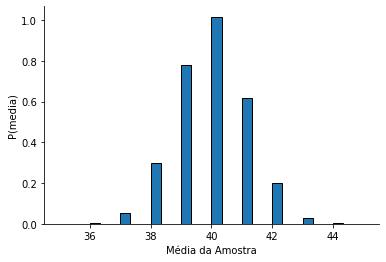

In [19]:
plt.hist(values, bins=30, edgecolor='k', density=True)
plt.xlabel('Média da Amostra')
plt.ylabel('P(media)')

despine()

[42. 39. 39. ... 40. 41. 40.]


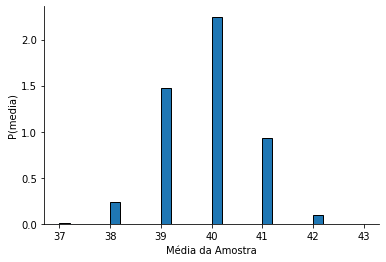

In [20]:
N = 10000
values = np.zeros(N)
for i in range(N):
    sample = match_durations.sample(200, replace=True)
    values[i] = sample.mean()//60
print(values)

plt.hist(values, bins=30, edgecolor='k', density=True)
plt.xlabel('Média da Amostra')
plt.ylabel('P(media)')

despine()

[40. 40. 39. ... 40. 40. 40.]


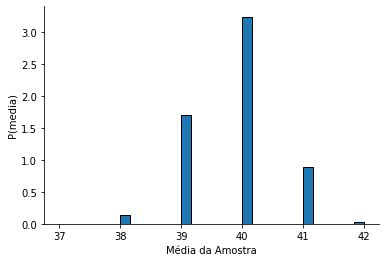

In [21]:
N = 10000
values = np.zeros(N)
for i in range(N):
    sample = match_durations.sample(300, replace=True)
    values[i] = sample.mean()//60
print(values)

plt.hist(values, bins=30, edgecolor='k', density=True)
plt.xlabel('Média da Amostra')
plt.ylabel('P(media)')

despine()

[40. 40. 39. ... 39. 39. 40.]


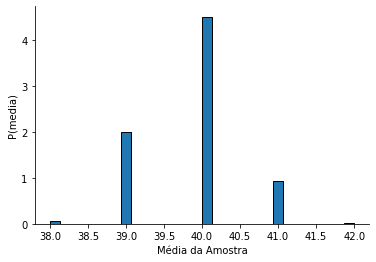

In [22]:
N = 10000
values = np.zeros(N)
for i in range(N):
    sample = match_durations.sample(400, replace=True)
    values[i] = sample.mean()//60
print(values)

plt.hist(values, bins=30, edgecolor='k', density=True)
plt.xlabel('Média da Amostra')
plt.ylabel('P(media)')

despine()

[39. 40. 39. ... 39. 40. 40.]


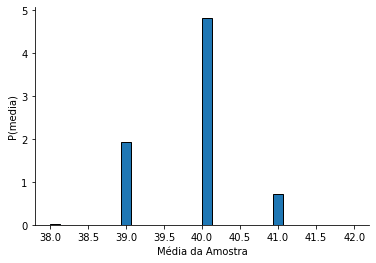

In [23]:
N = 10000
values = np.zeros(N)
for i in range(N):
    sample = match_durations.sample(500, replace=True)
    values[i] = sample.mean()//60
print(values)

plt.hist(values, bins=30, edgecolor='k', density=True)
plt.xlabel('Média da Amostra')
plt.ylabel('P(media)')

despine()

[40. 39. 40. ... 41. 41. 40.]


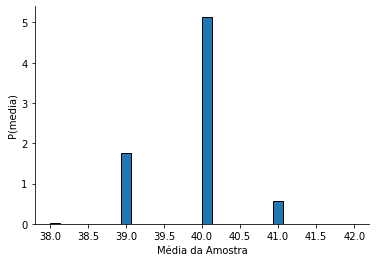

In [24]:
N = 10000
values = np.zeros(N)
for i in range(N):
    sample = match_durations.sample(600, replace=True)
    values[i] = sample.mean()//60
print(values)

plt.hist(values, bins=30, edgecolor='k', density=True)
plt.xlabel('Média da Amostra')
plt.ylabel('P(media)')

despine()

[40. 39. 39. ... 40. 40. 40.]


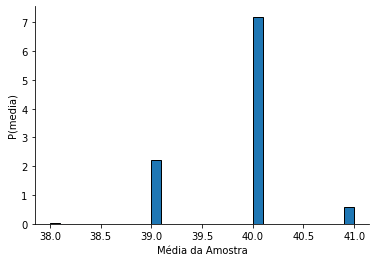

In [25]:
N = 10000
values = np.zeros(N)
for i in range(N):
    sample = match_durations.sample(700, replace=True)
    values[i] = sample.mean()//60
print(values)

plt.hist(values, bins=30, edgecolor='k', density=True)
plt.xlabel('Média da Amostra')
plt.ylabel('P(media)')

despine()

### Análise dos resultados
Utilizando um número n de amostras menor que o tamanho da população total (duração de todas as partidas do univeso estudado), fomos capases de plotar o histograma acima a partir dos seguintes passos.


*   Definimos o número de partidas que seriam analisadas **N**
*   Criamos uma amostra com o tamanho definido à partir da obtenção de elementos aleatórios dentro da população geral utilizando a função "sample".
*   Repetimos o passo anterior realizando a reposição dos elementos na amostra **N**

### Resultados

Observamos que para valores suficientemente grandes (próximos ao tamanho da população) os valores esperados se aproximam do intevalo analisado à partir da observação da população como um todo.

Ao analisarmos o histograma acima, podemos inferir que a média de duração das partidas tem valores próximos à 38 minutos, e utilizando as funções "percentile" podemos observar com 95% de confiança que a média está dentro do intervalo esperado.

E por fim, utilizando a média bruta da população, constatamos nossos cálculos.



In [26]:
np.percentile(values, 2.5)

39.0

In [27]:
np.percentile(values, 97.5)

41.0

In [28]:
duration_classifier, duration_percentage = classifyMatchDurations(match_durations)
print(duration_classifier)
print(duration_percentage)

[17, 90, 426, 1046, 833, 310, 134]
[0.01, 0.03, 0.15, 0.37, 0.29, 0.11, 0.05]


In [29]:
np.mean(match_durations.values//60)

39.84103641456583

# Testes de Hipótese

#### Em uma partida, qual a distribuição de classes da equipe vencedora? Ou seja, a equipe vencedora é composta por qual porporção de heroes melee e ranged?

Para testar a hipótese nula de seleção uniforme, os testes a seguir definirão nossa amostragem acerca da distribuição das classes da equipe vencedora.

Buscaremos demonstrar que a seleção de uma classe dentro da equipe vencedora é proporcional a seleção da mesma dentro da população.

In [30]:
match_df = pd.read_sql_query(
'''
SELECT match_id, radiant_win
FROM match
''', conn)

match_df

,match_id,radiant_win
0,2001166109,1
1,2001166147,1
2,2001166161,0
3,2001166193,1
4,2001166234,1
5,2001166335,0
6,2001166518,1
7,2001166557,0
8,2001166667,0
9,2001166670,1


A seguir definimos as funções:


*  **total_variation:** Calculamos a TVD para mensuras as proporções entre os vetores de amostras e da população
*  **sample_proportion:** Define amostras das proporções de cada classe
*  **classifyAttackType:** Define através dos dados a proporção de cada classe dentro da partida à partir do cruzamento de dados com a equipe vencedora


In [31]:
def total_variation(p, q):
    return np.sum(np.abs(p - q)) / 2
  
def sample_proportion(pop_size, prop, n=10000):
  assert(prop >= 0)
  assert(prop <= 1)

  grupo = pop_size * prop
  resultados = np.zeros(n)
  for i in range(n):
      sample = np.random.randint(0, pop_size, 100)
      resultados[i] = np.sum(sample < grupo)
  return resultados

def classifyAttackType(match_df):
  class_distribution = [0] * 2
  melee_count = 0
  ranged_count = 0
  total_records = 0
  
  
  for match in match_df.values:
    p_query = "SELECT p.player_slot, h.attack_type FROM player p JOIN heroes h ON p.hero_id = h.hero_id WHERE player_match_id = {}".format(match[0])
    #print(p_query)

    player_df = pd.read_sql_query(p_query, conn)
    player_df

    #< 5 é radiant
    #> 5 é Dire

    RADIANT = 1
    TEAM_SIZE = 5


    winner_team = match[1]

    if winner_team == RADIANT:
      for player in player_df.values:
        if player[0] < 5:
          if player[1] == "Melee":
            melee_count += 1
          elif player[1] == "Ranged":
            ranged_count += 1
    elif winner_team != RADIANT:
      for player in player_df.values:
        if player[0] > 5:
          if player[1] == "Melee":
            melee_count += 1
          elif player[1] == "Ranged":
            ranged_count += 1

    class_distribution[0] = melee_count
    class_distribution[1] = ranged_count
  total_records = class_distribution[0] + class_distribution[1]
  return ([class_distribution[0]/(total_records), class_distribution[1]/(total_records)])

In [32]:
idx = ['Melee', 'Ranged']
df = pd.DataFrame(index=idx)
df['pop'] = classifyAttackType(match_df)

for n in [10,50,100,200,300,400,500,600,700]:
  sample = match_df.sample(n, replace=True)
  df['sample {}'.format(n)] = classifyAttackType(sample) 

df

,pop,sample 10,sample 50,sample 100,sample 200,sample 300,sample 400,sample 500,sample 600,sample 700
Melee,0.496708,0.42,0.448,0.52,0.51,0.492,0.5025,0.498,0.502335,0.498286
Ranged,0.503292,0.58,0.552,0.48,0.49,0.508,0.4975,0.502,0.497665,0.501714


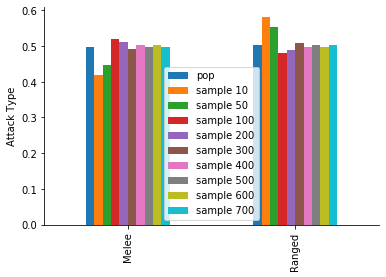

In [33]:
df.plot.bar()
plt.ylabel('Propopção')
plt.ylabel('Attack Type')
despine()

In [34]:
tv = total_variation(df['sample 100'], df['pop'])
tv

0.02329177755988235

In [35]:
total_variation(df['sample 100'], df['sample 400'])

0.017500000000000043

In [36]:
N = 10000
TVDS = np.zeros(shape=(10000, len(df.index)))
for i, g in enumerate(df.index):
    p = df.loc[g]['pop']
    TVDS[:, i] = sample_proportion(N, p) / 100

In [37]:
TVDS

array([[0.59, 0.51],
       [0.5 , 0.57],
       [0.55, 0.53],
       ...,
       [0.54, 0.57],
       [0.47, 0.47],
       [0.53, 0.55]])

In [38]:
all_distances = []
for i in range(TVDS.shape[0]):
    all_distances.append(total_variation(df['pop'], TVDS[i]))

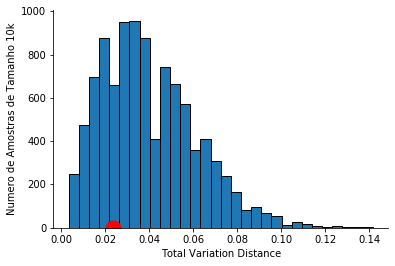

In [39]:
plt.hist(all_distances, bins=30, edgecolor='k')
plt.ylabel('Numero de Amostras de Tamanho 10k')
plt.xlabel('Total Variation Distance')
plt.plot([tv], [0], 'ro', ms=15)
despine()

In [40]:
np.percentile(all_distances, 2.5)

0.008291777559882335

In [41]:
np.percentile(all_distances, 97.5)

0.08999999999999997

### Resultados
Com um número suficientemente grande de amostras, podemos mostrar que nossa hipótese nula pode confirmar a seleção uniforme de dados demonstrando que a proporção de cada classe na equipe vencedora tem o formato aproximado de [0.4 +- 0.1, 0.4 +- 0.1]. 

Em outras palavras, a equipe vencedora, majoritariamente é composta por uma proporção próxima da uniformidade de heroes das duas classes.

Podemos ainda confirmar os dados a partir da análise do intervalo de confiança que nos mostra que com 95% de certeza, o TVD está entre 0.009 e 0.08.

## Regressão Linear:

Nessa consulta, o objetivo foi criar uma tabela com todos os jogadores de todas as partidas e identificar quais foram os "Last Hits" e os "Kills" de seus respectivos heróis.

Last hit é o termo utilizado para descrever quando o herói dá o golpe derradeiro em unidades NPC's (creeps) inimigos. Quando o last hit é desferido, o herói recebe uma pequena recompensa em gold no momento.

Kills armazena a quantidade de heróis que foram mortos pelo jogador até o fim do jogo.

Ambas são caratecrísticas importantes que podem oferecer vantagens para os jogadores no decorrer da partida.

A previsão que buscamos realizar utilizando regressão linear simples é:
"Prever qual o número de heroís mortos pelo jogador no fim do jogo observando o número de last hits totais do jogador na partida"

In [42]:
df_killsLastHits = pd.read_sql_query(
'''
SELECT hero_name "Hero Name", last_hits "Last hits", kills "Kills" 
FROM player AS P
INNER JOIN(
    SELECT hero_id id, localized_name hero_name
    FROM heroes
)AS H
ON P.hero_id = H.id
''', conn)

df_killsLastHits

,Hero Name,Last hits,Kills
0,Ember Spirit,51,8
1,Necrophos,4,1
2,Wraith King,52,1
3,Vengeful Spirit,7,2
4,Slardar,65,1
5,Lion,12,1
6,Templar Assassin,43,1
7,Spectre,43,1
8,Shadow Shaman,10,1
9,Omniknight,59,2


In [43]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

Abaixo, para efeito de visualização, temos o gráfico plotado com as informações de kills e de last hits dos players

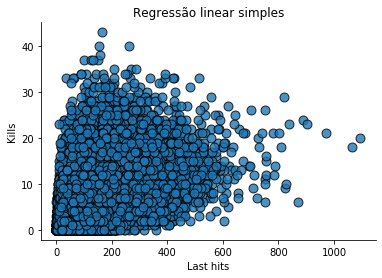

In [44]:
x = df_killsLastHits["Last hits"].values
y = df_killsLastHits["Kills"].values

plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.xlabel('Last hits')
plt.ylabel('Kills')
plt.title('Regressão linear simples')
despine()

Supomos que existem constantes $\alpha$ (alfa) e $\beta$ (beta) tais que:
$$\hat{y}_i = \beta x_i + \alpha + \epsilon_i$$

O ideal é que possamos capturar o valor médio de $y_i$ para grupos de valores próximos em $x_i$. $\epsilon_i$ é um termo de erro (esperançosamente pequeno) que representa o fato de que existem outros fatores não explicados por este modelo simples.

Para qualquer escolha de alfa e beta teremos uma saída prevista para cada entrada $x_i$. Como sabemos a saída real $y_i$, podemos calcular o erro de cada par e computar o valor $\epsilon_i$. Quanto o menor for o valor de $\epsilon_i$, menor será a influência de outros fatores não explicados neste modelo.


In [45]:
def error(alpha, beta, x, y):
    model = beta * x + alpha
    return y - model

Somamos os erros quadrados:

In [46]:
def sum_of_squared_errors(alpha, beta, x, y):
    return (error(alpha, beta, x, y) ** 2).sum()

A escolha do alfa mostra que quando observamos o valor médio da variável independente $x$, podemos predizer o valor médio da variável dependente $y$.

A escolha de beta significa que quando o valor de entrada aumenta pelo desvio padrão de $x$, a previsão de $y$ aumenta pela correlação entre $x$ e $y$ multiplicada pelo desvio padrão de $y$ (correlationxy * np.std(y)). No caso em que $x$ e $y$ estão perfeitamente correlacionados, um aumento de um desvio padrão em $x$ resulta em um aumento de um desvio padrão de $y$ na predição. Quando eles são perfeitamente anti-correlacionados, o aumento em $x$ resulta em uma diminuição no valor da previsão. E quando a correlação é zero, o beta é zero, o que significa que as alterações em $x$ não afetam a previsão.

In [47]:
from scipy import stats as ss

def least_squares_fit(x, y):
    correlationxy = ss.pearsonr(x, y)[0]
    beta = correlationxy * np.std(y, ddof=1) / np.std(x, ddof=1)
    alpha = np.mean(y) - beta * np.mean(x)
    return alpha, beta

Cálculo do alpha e do beta.

Text(0.5, 1.0, 'Regressão linear simples')

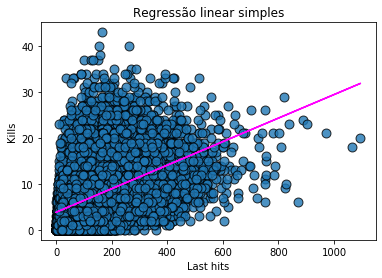

In [48]:
x = df_killsLastHits['Last hits'].values
y = df_killsLastHits['Kills'].values
alpha, beta = least_squares_fit(x, y)
y_model = beta * x + alpha
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y_model, color='magenta')
plt.xlabel('Last hits')
plt.ylabel('Kills')
plt.title('Regressão linear simples')

In [49]:
alpha, beta

(3.8240645745671573, 0.025621588923095236)

Observando a equação "y_model = beta * x + alpha", e com os valores de alpha e de beta, podemos interpretar os dados e prever o quanto espera-se que os jogadores matem de heróis observando a quantidade de last hits totais dados por cada jogador na partida.

Por exemplo, caso o jogador não dê last hits, espera-se que ele mate, na média, aproximadamente 3.6151 heróis em uma partida, para chegar neste valor basta colocar beta = 0 na fórmula e pegar o valor resultante de y_model. Porém, se na partida ele der 300 last hits, espera-se que ele mate na média, aproximadamente, 8.0396 heróis, para chegar este valor basta fazer x = 300 e observar o valor resultante de y_model.

In [50]:
def total_sum_of_squares(y):
    return ((y - y.mean()) ** 2).sum()

def r_squared(alpha, beta, x, y):
    return 1.0 - (sum_of_squared_errors(alpha, beta, x, y) /
                  total_sum_of_squares(y))

Vamos agora calcular o $R^2$. Seu resultado deve ser no mínimo $0$ e no máximo $1$.

In [51]:
r_squared(alpha, beta, x, y)

0.21538066962769853

Quanto maior for o $R^2$, melhor o nosso modelo se ajusta aos dados. Neste modelo calculamos que o $R^2$ é $0.21$, o que nos mostra que o nosso modelo não está tão forte e que existem outros fatores em jogo.
Em baixo, calculamos a raiz de $R^2$ para encontrar a correlação.

In [52]:
r_squared(alpha, beta, x, y) ** 0.5

0.4640912298543235

Para efeito de comparação, utilizamos o Coeficiente de Correlação de Pearson.

In [53]:
ss.pearsonr(x, y)[0]

0.46409122985432333

-> Bootstrap na Regressão

A regressão foi realizada em uma amostra, ou seja, qualquer estatística que obtemos vêm com erros. Os coeficientes da nossa regressão: $\alpha$ e $\beta$ possuem erros. Além da correlação $r$ e do $R^2$. 
Para saber a variablidade de tais estimativas, usaremos Bootstrap. O código abaixo faz um Bootstrap de: $\alpha$, $\beta$ e $R^2$.


In [54]:
def bootstrap_regression(df, n=10000, size=None):
    if size is None:
        size = len(df)
    
    alphas = np.zeros(n)
    betas = np.zeros(n)
    rs = np.zeros(n)

    for i in range(n):
        sample = df.sample(size, replace=True)
        x = sample['Last hits'].values
        y = sample['Kills'].values
        alpha, beta = least_squares_fit(x, y)
    
        alphas[i] = alpha
        betas[i] = beta
        rs[i] = ss.pearsonr(x, y)[0] ** 2
    return alphas, betas, rs

In [55]:
alphas, betas, rs = bootstrap_regression(df_killsLastHits)

Plotando o gráfico de coluna para o alpha, temos:

3.824317973683285
3.738632310082383 3.910293125432357


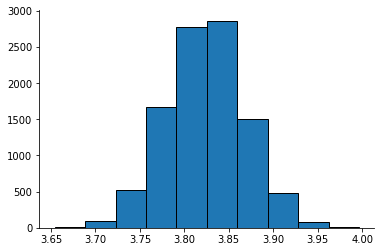

In [56]:
plt.hist(alphas, edgecolor='k')
lower = np.percentile(alphas, 2.5)
upper = np.percentile(alphas, 97.5)
despine()
print(alphas.mean())
print(lower, upper)

Plotando o gráfico de coluna para o beta, temos:

0.025618127572659823
0.024928590640886882 0.026195595880545066


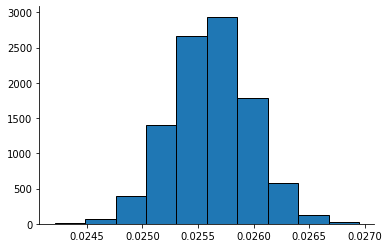

In [57]:
plt.hist(betas, edgecolor='k')
lower = np.percentile(betas, 2.5)
upper = np.percentile(betas, 95)
despine()
print(betas.mean())
print(lower, upper)

0.21532941489582413
0.20611576861061748 0.22464946890444343


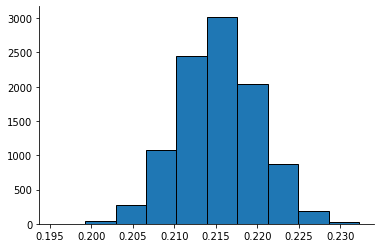

In [58]:
plt.hist(rs, edgecolor='k')
lower = np.percentile(rs, 2.5)
upper = np.percentile(rs, 97.5)
despine()
print(rs.mean())
print(lower, upper)

-> Aprendizado/classificação:

https://pt.wikipedia.org/wiki/Aprendizado_de_m%C3%A1quina

Aprendizado supervisionado: São apresentadas ao computador exemplos de entradas e saídas desejadas, fornecidas por um "professor". O objetivo é aprender uma regra geral que mapeia as entradas para as saídas.

Em classificação, entradas são divididas em duas ou mais classes, e o aprendiz deve produzir um modelo que vincula entradas não vistas a uma ou mais dessas classes (classificação multi-etiquetada). Isso é tipicamente abordado de forma supervisionada. A filtragem de spam é um exemplo de classificação, em que as entradas são as mensagens de emails (ou outros) e as classes são "spam" ou "não spam".

http://www.cienciaedados.com/conceitos-fundamentais-de-machine-learning/

É o termo usado sempre que o programa é “treinado” sobre um conjunto de dados pré-definido. Baseado no treinamento com os dados pré-definidos, o programa pode tomar decisões precisas quando recebe novos dados. Exemplo: Pode-se usar um conjunto de dados de recursos humanos para treinamento da Machine Learning, que tenha tweets marcados como positivos, negativos e neutros e assim treinar um classificador de análise de sentimento.

A classificação é uma sub-categoria de aprendizagem supervisionada. Classificação é o processo de tomar algum tipo de entrada e atribuir um rótulo a ela. Sistemas de classificação são usados ​​geralmente quando as previsões são de natureza distinta, ou seja, um simples “sim ou não”. Exemplo: Mapeamento de uma imagem de uma pessoa e classificação como masculino ou feminino.

KNN

Na situação geral, temos alguns pontos de dados e temos um conjunto de rótulos correspondente. Os rótulos podem ser True e False, indicando se cada entrada satisfaz alguma condição como "é spam?" Ou "é venenoso?" Ou "seria agradável assistir". Ou podem ser categorias, como a classificação indicativa de filmes (G, PG, PG-13, R, NC-17). Ou eles poderiam ser os nomes dos candidatos presidenciais. Ou poderiam ser linguagens de programação favoritas.

Tentar prever quais os itens que os jogadores terminarão a partida
Observando como atributo primário, tipos de ataque, level

-> KNN tridimensional: Kills x Deaths x Assists

A ideia aqui foi plotar um gráfico tridimensional de eixos Kills, Deaths e Assists dos jogadores de todas as partidas. Com o gráfico plotado, a ideia é através dos vizinhos mais próximos, tentar prever se o jogador saiu vitorioso ou não de uma partida.

In [59]:
df_prediction = pd.read_sql_query(
'''
SELECT hero_name 'Hero Name', kills 'Kills', assists 'Assists', deaths 'Deaths', player_slot 'Team', radiant_win 'Resultado'
FROM match AS M
INNER JOIN(
    SELECT *
    FROM player AS P
    INNER JOIN(
        SELECT hero_id id, localized_name hero_name
        FROM heroes
    ) AS H
    ON P.hero_id = H.id
) AS K
ON M.match_id = K.player_match_id
''', conn)

df_prediction

,Hero Name,Kills,Assists,Deaths,Team,Resultado
0,Ember Spirit,8,4,0,0,1
1,Necrophos,1,7,1,1,1
2,Wraith King,1,4,2,2,1
3,Vengeful Spirit,2,2,2,3,1
4,Slardar,1,1,1,4,1
5,Lion,1,3,5,128,1
6,Templar Assassin,1,0,4,129,1
7,Spectre,1,3,1,130,1
8,Shadow Shaman,1,3,3,131,1
9,Omniknight,2,0,1,132,1


Text(0.5, 0.92, 'KDA em três dimensões')

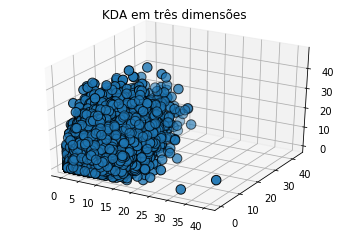

In [60]:
xpre = df_prediction["Deaths"].values
ypre = df_prediction["Kills"].values
zpre = df_prediction["Assists"].values

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xpre, ypre, zpre, s=90, edgecolors='k')
plt.title("KDA em três dimensões")

-> KNN: Número de jogadores x KDA

KDA = $(kills + assists)/MAX(1,deaths).$

A ideia é calcular o KDA de todos os jogadores de todos os jogos, e a partir do gráfico bidimensional gerado entre KDA e o índice de cada jogador, utilizar o algoritmo de vizinho mais próximo (KNN) para tentar prever se o jogador com determinado KDA saiu vencedor em sua partida.

In [61]:
df_kda_pre = pd.read_sql_query(
'''
SELECT hero_name 'Hero Name', kills Kills, assists Assists, deaths Deaths, (CAST(kills AS float)+CAST(assists AS float))/CAST(MAX(1, deaths) AS float) "KDA Ratio"
FROM player AS P
INNER JOIN(
    SELECT hero_id id, localized_name hero_name
    FROM heroes
) AS H
ON P.hero_id = H.id
''', conn)

df_kda_pre

,Hero Name,Kills,Assists,Deaths,KDA Ratio
0,Ember Spirit,8,4,0,12.000000
1,Necrophos,1,7,1,8.000000
2,Wraith King,1,4,2,2.500000
3,Vengeful Spirit,2,2,2,2.000000
4,Slardar,1,1,1,2.000000
5,Lion,1,3,5,0.800000
6,Templar Assassin,1,0,4,0.250000
7,Spectre,1,3,1,4.000000
8,Shadow Shaman,1,3,3,1.333333
9,Omniknight,2,0,1,2.000000


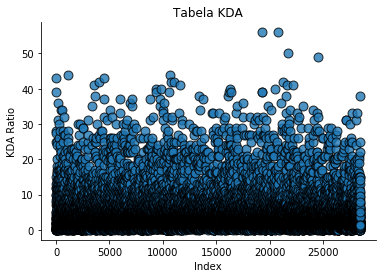

In [62]:
x_kda_pre = df_kda_pre.index
y_kda_pre = df_kda_pre["KDA Ratio"].values

plt.scatter(x_kda_pre, y_kda_pre, alpha=0.8, edgecolors='k', s=80)
plt.xlabel('Index')
plt.ylabel('KDA Ratio')
plt.title('Tabela KDA')
despine()